In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.fft import fft, ifftshift
import pandas as pd
import scipy.signal as signal
from datetime import datetime, timedelta

c:\miniconda\envs\molonari\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('seismes.csv')
df['event_date_time'] = pd.to_datetime(df['event_date_time'])
df['recording_date_time'] = pd.to_datetime(df['recording_date_time'])
df.head()

,event_date_time,event_date,event_time,recording_date_time,recording_date,recording_time,recording_duration,file
0,2018-11-18 20:32:00,2018-11-18,20:32:0,2018-11-18 01:22:16,2018-11-18,01:22:16,19:12:41,data/DonneesB23/2018-11/2018-11-18/2018-11-18T...
1,2018-11-30 17:42:00,2018-11-30,17:42:0,2018-11-30 07:31:32,2018-11-30,07:31:32,10:13:26,data/DonneesB23/2018-11/2018-11-30/2018-11-30T...
2,2018-12-23 23:14:45,2018-12-23,23:14:45,2018-12-23 20:19:50,2018-12-23,20:19:50,2:58:1,data/DonneesB23/2018-12/2018-12-23/2018-12-23T...
3,2019-02-22 10:27:55,2019-02-22,10:27:55,2019-02-22 00:23:05,2019-02-22,00:23:05,40:21:23,data/DonneesB23/2019-02/2019-02-22/2019-02-22T...
4,2018-11-15 20:14:40,2018-11-15,20:14:40,2018-11-15 01:25:46,2018-11-15,01:25:46,19:10:24,data/DonneesB23/2018-11/2018-11-15/2018-11-15T...


In [3]:
fichiers = df['file']
arrival = df['event_time']
arrival

0      20:32:0
1      17:42:0
2     23:14:45
3     10:27:55
4     20:14:40
        ...   
80      2:21:0
81     11:40:0
82    13:37:30
83     22:43:0
84     21:14:0
Name: event_time, Length: 85, dtype: object

In [4]:
fs = 125.
Y = []  #signaux
X = []  #abscisses
for i in range(85):
    y = np.fromfile(fichiers[i], dtype=np.int32)
    n = len(y)
    Y.append(y)
    X.append(np.arange(0, n/fs, 1./fs))
len(Y[5])

11012352

In [5]:
def get_file(event_i) :
    file = df.loc[event_i, 'file']
    return np.fromfile(file, dtype=np.int32)

In [6]:
df.loc[3, 'file']

'data/DonneesB23/2019-02/2019-02-22/2019-02-22T00_23_05.800000'

## Filtres

In [7]:
def plot(event_i, units='seconds', plot_event = True, signal=None) :
    file = df.loc[event_i, 'file']
    print(file)
    fs = 40.
    y = np.fromfile(file, dtype=np.int32)
    if signal is not None :
        y = signal

    if units == 'date' :
        x = np.arange(len(y)) / fs
        date = df.loc[event_i, 'recording_date_time']
        timestamps = [date + timedelta(seconds=t) for t in x]
        plt.figure(figsize=(20, 8))
        plt.plot(timestamps, y)

        if plot_event :
            event_date = df.loc[event_i, 'event_date_time']
            plt.axvline(event_date, color='r')
    elif units == 'seconds' :
        x = np.arange(len(y)) / fs
        plt.figure(figsize=(20, 8))
        plt.plot(x, y)

        if plot_event :
            event_date = df.loc[event_i, 'event_date_time']
            start_date = df.loc[event_i, 'recording_date_time']
            event = (event_date - start_date).total_seconds()
            plt.axvline(event, color='r')


In [8]:
def bp(y, fs=40, lowcut=.05, highcut=.1, order=3) :
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.lfilter(b, a, y)
def hp(y, fs=40, lowcut=.5, highcut=2, order=3) :
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.lfilter(b, a, y)
def sta_lta(y, fs=40, sta=10*60, lta=3*3600) :
    sta = int(sta * fs)
    lta = int(lta * fs)
    sta = signal.convolve(y**2, np.ones(sta)/sta, 'same')
    lta = signal.convolve(y**2, np.ones(lta)/lta, 'same')
    return sta / lta
def bs(y, fs=40, lowcut=.1, highcut=2, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandstop')
    return signal.lfilter(b, a, y)

In [9]:
fichier_numero = 3
y = get_file(fichier_numero)
y = (y-np.mean(y)) / np.std(y)
y_low = bp(y)
y_low_w = signal.wiener(y_low, mysize=1000)
y_high = hp(y)
y_high_w = signal.wiener(y_high, mysize=1000)
y_cut = bs(y)
y_cut_w = signal.wiener(y_cut, mysize=1000)

data/DonneesB23/2018-11/2018-11-15/2018-11-15T01_25_46.425000


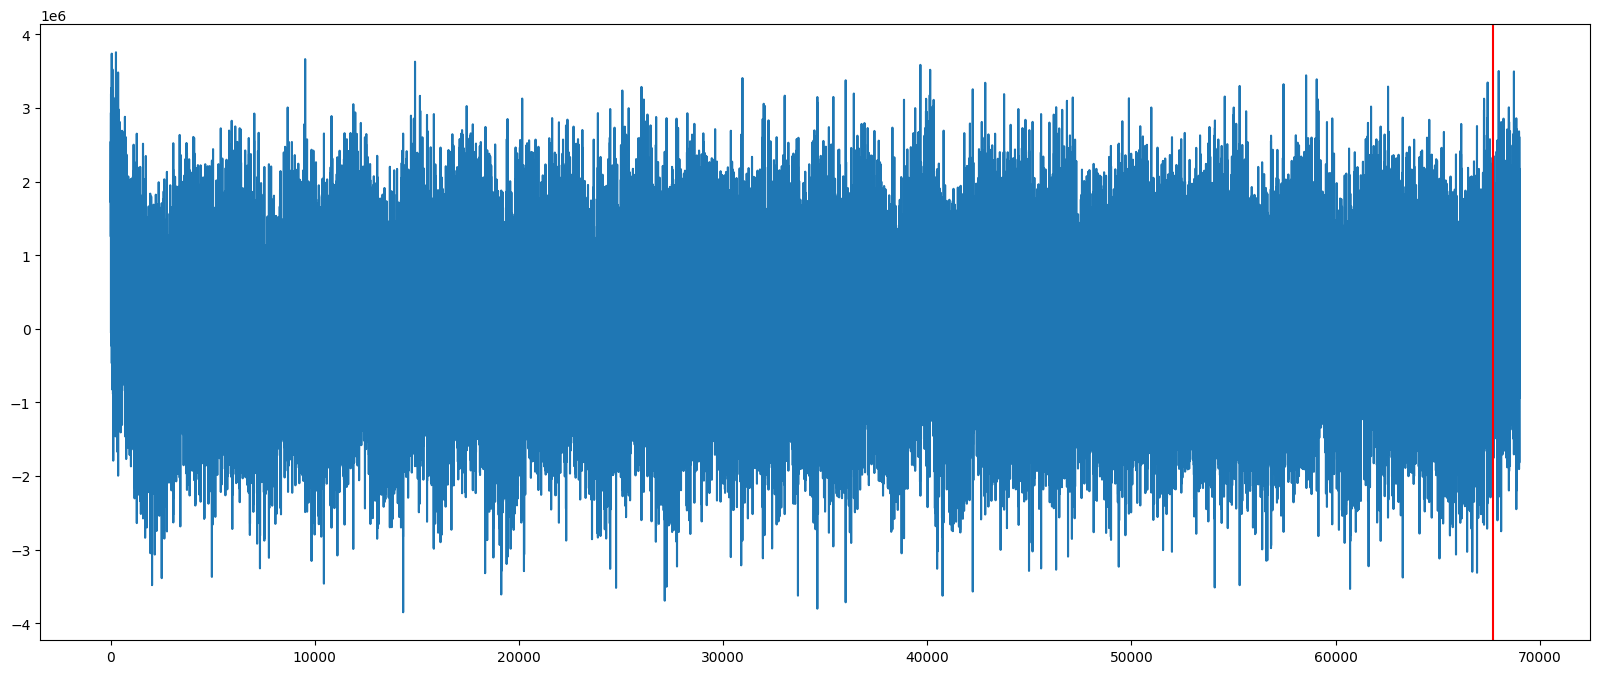

In [10]:
plot(4)

## Calcul DSP(b)

In [15]:
# Récupère le bruit avant l'évènement dans des enregistrements où il y a un séisme
def bruit(df):
    B = []
    k = 0
    for i in range(len(df)):
        y = get_file(i)
        B.append([])
        event_date = df.loc[i, 'event_date_time']
        start_date = df.loc[i, 'recording_date_time']
        # Calcul de la position de l'événement en secondes à partir du début de l'enregistrement
        event = (event_date - start_date).total_seconds()
        for i in range(len(y)):
            if i < int(event):
                B[k].append(y[i])
        k +=1
    return B

In [16]:
b = bruit(df)

In [17]:
len(b)

85

In [18]:
def dsp(y, plot):
    fs = 40  # Fréquence d'échantillonnage en Hz
    frequencies, psd = signal.welch(y, fs, nperseg=1024)
    if plot == True:
        # Tracer la DSP
        plt.semilogy(frequencies, psd)
        # Tracer la PSD
        plt.title('Densité Spectrale de Puissance')
        plt.xlabel('Fréquence (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.show()
    else:
        return frequencies, psd

In [19]:
len(dsp(b[0], False)[1])
#plt.semilogy(dsp(b[0]))

513

In [20]:
#Moyenne des dsp d'une liste
def moyenne_dsp(y):
    n = len(y)
    print(n)
    DSP = []
    for i in range(n):
        d = dsp(y[i], False)[1]
        DSP.append(d)
    longueur_max = max(len(d) for d in DSP)
    DSP_padded = [np.pad(d, (0, longueur_max - len(d))) for d in DSP]
    D = np.array(DSP_padded)
    print(D)
    moyenne = np.mean(D, axis = 0)
    return moyenne

85


c:\miniconda\envs\molonari\lib\site-packages\scipy\signal\_spectral_py.py:1961: UserWarning: nperseg = 1024 is greater than input length  = 369, using nperseg = 369
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\miniconda\envs\molonari\lib\site-packages\scipy\signal\_spectral_py.py:1961: UserWarning: nperseg = 1024 is greater than input length  = 659, using nperseg = 659
  warnings.warn('nperseg = {0:d} is greater than input length '


[[3.30043756e+10 6.08568168e+10 2.25840560e+10 ... 1.41169129e+04
  1.35736373e+04 7.08046228e+03]
 [2.65229035e+10 1.95842571e+11 4.73456980e+10 ... 1.69487450e+04
  2.14024397e+04 1.10769784e+04]
 [4.08897463e+10 2.47141905e+10 6.40070012e+10 ... 1.48415144e+04
  1.58929890e+04 6.56690387e+03]
 ...
 [7.75896149e+10 6.75872693e+10 2.25935978e+11 ... 2.08572478e+04
  1.63962484e+04 8.09543752e+03]
 [4.65586866e+10 1.44339428e+11 1.88384002e+10 ... 1.14240000e+04
  1.15137092e+04 4.88151413e+03]
 [9.19565057e+10 2.70609206e+11 1.38174348e+11 ... 1.62728657e+04
  2.06320052e+04 1.11862252e+04]]


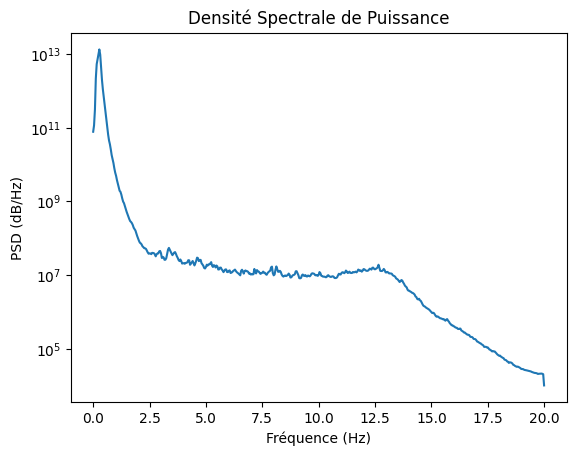

In [21]:
B_MOY = moyenne_dsp(b)
plt.semilogy(dsp(b[0], False)[0], B_MOY)
# Tracer la PSD
plt.title('Densité Spectrale de Puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('PSD (dB/Hz)')
plt.show()

85
[[3.30043756e+10 6.08568168e+10 2.25840560e+10 ... 1.41169129e+04
  1.35736373e+04 7.08046228e+03]
 [2.65229035e+10 1.95842571e+11 4.73456980e+10 ... 1.69487450e+04
  2.14024397e+04 1.10769784e+04]
 [4.08897463e+10 2.47141905e+10 6.40070012e+10 ... 1.48415144e+04
  1.58929890e+04 6.56690387e+03]
 ...
 [7.75896149e+10 6.75872693e+10 2.25935978e+11 ... 2.08572478e+04
  1.63962484e+04 8.09543752e+03]
 [4.65586866e+10 1.44339428e+11 1.88384002e+10 ... 1.14240000e+04
  1.15137092e+04 4.88151413e+03]
 [9.19565057e+10 2.70609206e+11 1.38174348e+11 ... 1.62728657e+04
  2.06320052e+04 1.11862252e+04]]


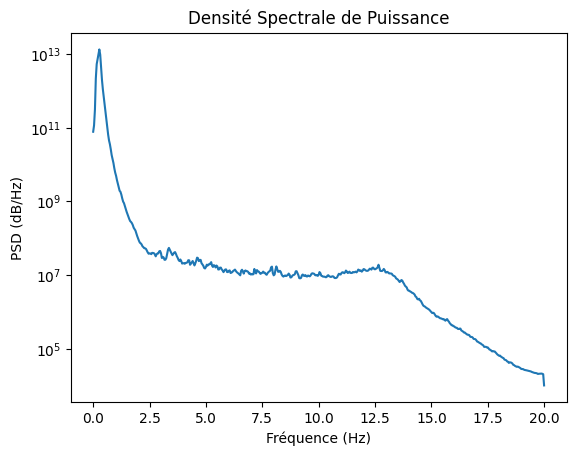

In [22]:
B_MOY = moyenne_dsp(b)
plt.semilogy(dsp(b[0], False)[0], B_MOY)
# Tracer la PSD
plt.title('Densité Spectrale de Puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('PSD (dB/Hz)')
plt.show()

## Calcul DSP(b+s)

In [23]:
y = get_file(3)

36290.0


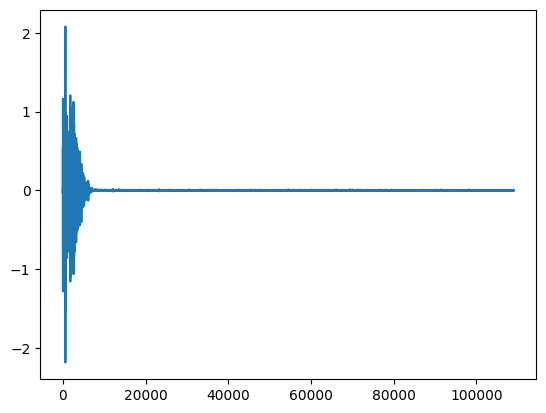

In [24]:
y = get_file(3)
fs = 40.
y = (y-np.mean(y)) / np.std(y)
y_low = bp(y)
y_low_w = signal.wiener(y_low, mysize=1000)
event_date = df.loc[3, 'event_date_time']
start_date = df.loc[3, 'recording_date_time']
# Calcul de la position de l'événement en secondes à partir du début de l'enregistrement
event = (event_date - start_date).total_seconds()
print(event)
s = y_low_w[int(event*40):]
x = np.arange(len(s)) / fs
plt.plot(x, s)

In [25]:
def plot_fft(i, fs):
    # Calcul de la transformée de Fourier
    y = get_file(i)
    y = (y-np.mean(y)) / np.std(y)
    y_low = bp(y)
    y_low_w = signal.wiener(y_low, mysize=1000)
    fourier_transform = np.fft.fft(y_low_w)
    F = np.abs(fourier_transform)
    L = F.tolist()
    
    # Calcul des fréquences correspondantes
    frequencies = np.fft.fftfreq(len(y_low_w), 1/fs)
    
    # Plot du graphe en amplitude
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, F)
    plt.xlim(0, 1)
    plt.title('Transformée de Fourier')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()
    return frequencies[L.index(max(L))]

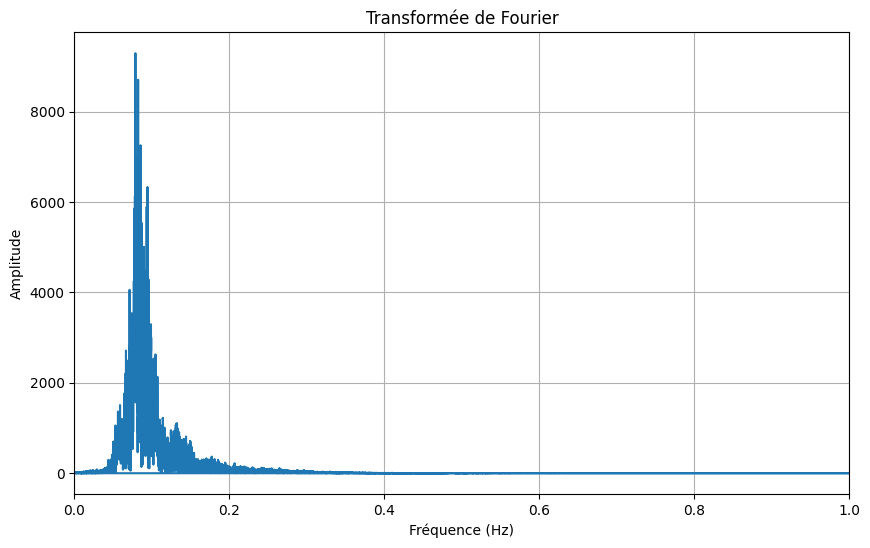

0.07872899275346358

In [26]:
plot_fft(3, 40)

In [27]:
def b_s(i, plot):
    y = get_file(i)
    y = (y-np.mean(y)) / np.std(y)
    y_low = bp(y)
    y_low_w = signal.wiener(y_low, mysize=1000)
    event_date = df.loc[i, 'event_date_time']
    start_date = df.loc[i, 'recording_date_time']
    # Calcul de la position de l'événement en secondes à partir du début de l'enregistrement
    event = (event_date - start_date).total_seconds()
    s = y_low_w[int(event)*40:]
    n = len(s)
    M = max(s)
    for i in range(1, int(n/700)):
        b = np.abs(s[700*i: 700*(i+1)])
        if max(b) < 0.17*M:
            I = i*700
            if plot == True:
                x = np.arange(len(s)) / fs
                print(I)
                plt.subplot(2,1,1)
                plt.plot(x, s)
                plt.axvline(I, color='r')
                plt.subplot(2,1,2)
                plt.plot(x, np.abs(s))
                plt.axvline(I, color='r')
            else:
                return I
        else:
            pass
    

data/DonneesB23/2019-02/2019-02-22/2019-02-22T00_23_05.800000


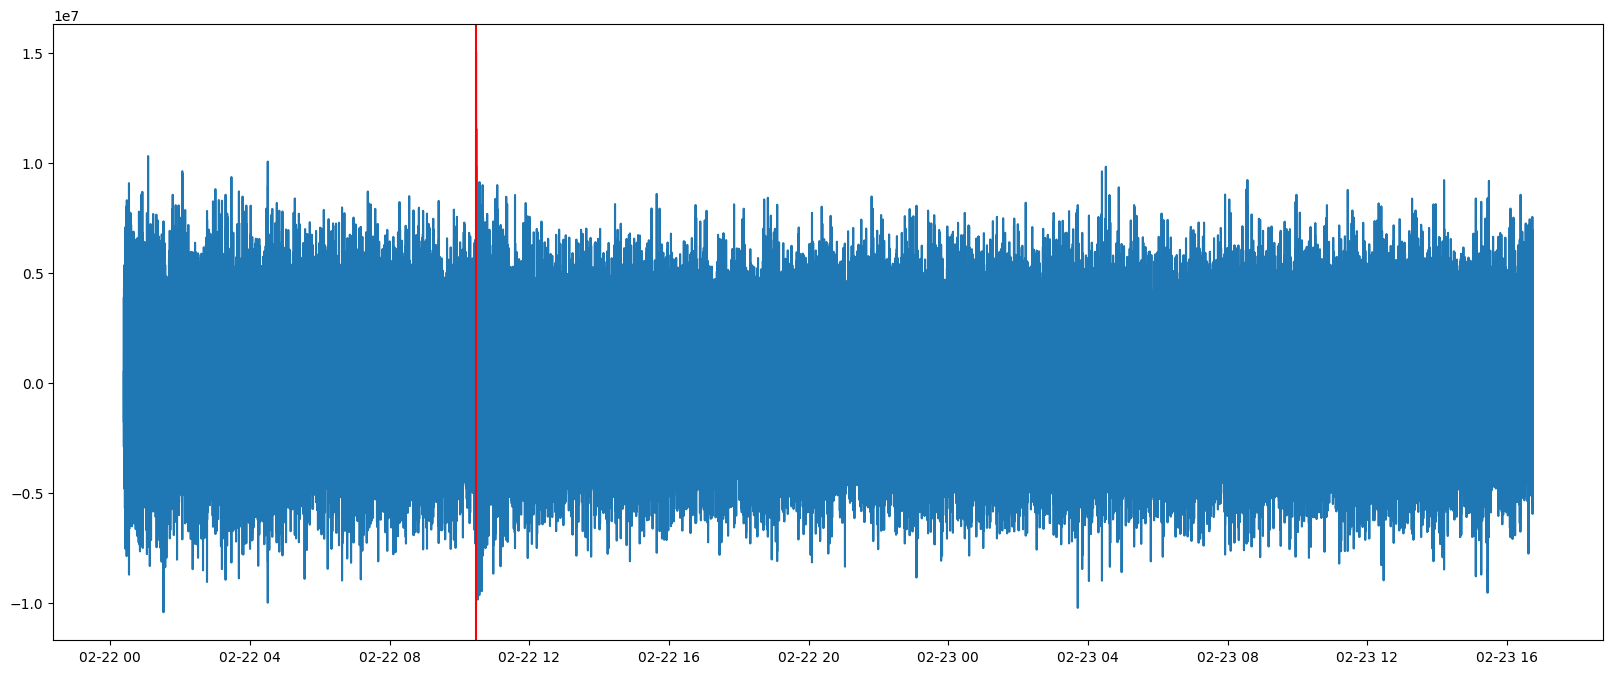

In [28]:
plot(fichier_numero, units='date', plot_event=True)

## Filtre de Wiener avec séisme nº3

In [29]:
y = get_file(3)
y_low = bp(y)
event_date = df.loc[i, 'event_date_time']
start_date = df.loc[i, 'recording_date_time']
# Calcul de la position de l'événement en secondes à partir du début de l'enregistrement
event = (event_date - start_date).total_seconds()
s = y_low_w[int(event)*40:]

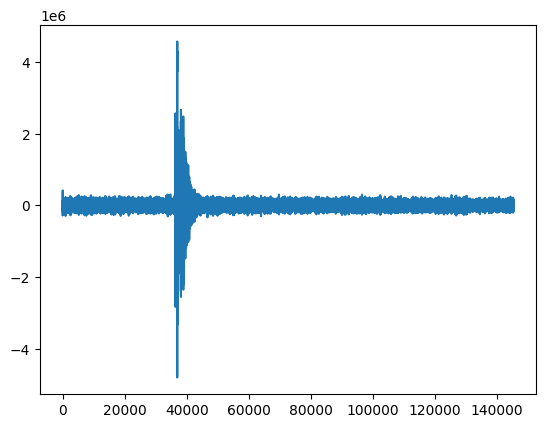

In [30]:
x = np.arange(len(y_low))/fs
plt.plot(x, y_low)

In [31]:
b_s_3 = y[int(event)*40 :int(b_s(3, False)) + int(event)*40]
b_s_3

array([1237024, 1289632, 1348000, ..., 2540848, 2487552, 2423008])

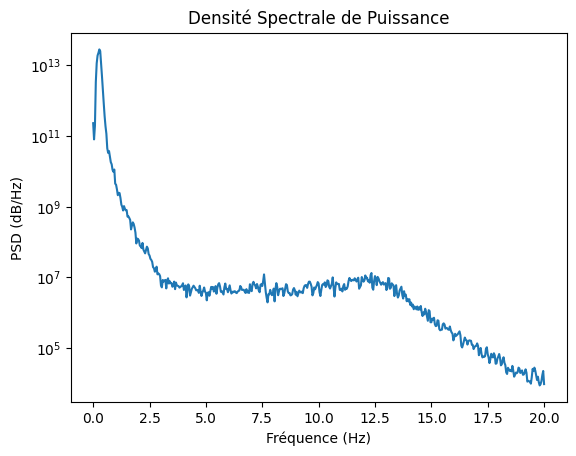

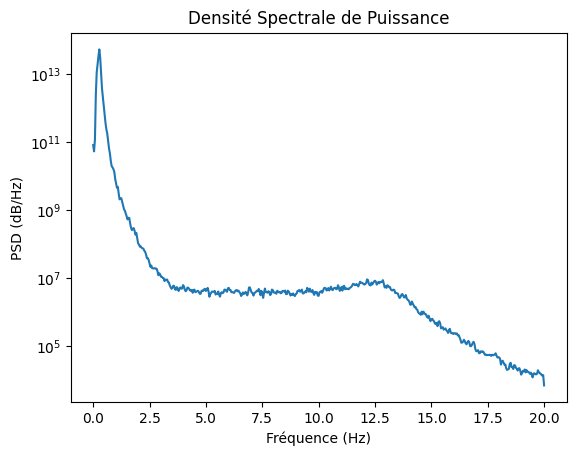

In [32]:
dsp(b_s_3, True)
dsp(b[3], True)

In [33]:
def W(i):
    dsp_s_b = dsp(b_s_3, False)[1]
    dsp_b = dsp(b[i],False)[1]
    return (dsp_s_b - dsp_b)/dsp_s_b


In [34]:
W = W(3)

c:\miniconda\envs\molonari\lib\site-packages\scipy\signal\_spectral_py.py:1961: UserWarning: nperseg = 1024 is greater than input length  = 513, using nperseg = 513
  warnings.warn('nperseg = {0:d} is greater than input length '


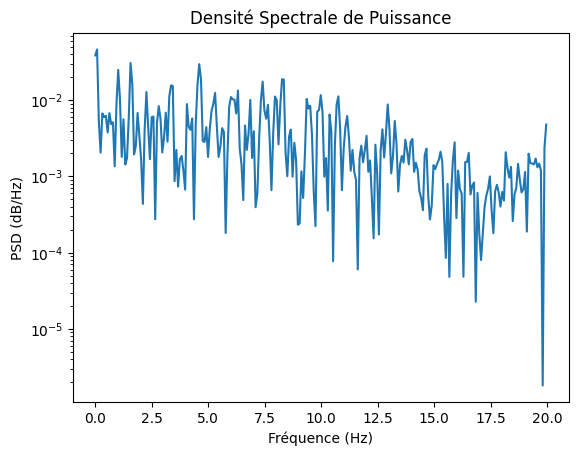

In [55]:
dsp(W, True)

In [53]:
w = np.fft.ifft(W)
w = np.fft.ifftshift(w)
s = np.convolve(w, y_low)

c:\miniconda\envs\molonari\lib\site-packages\scipy\signal\_spectral_py.py:1961: UserWarning: nperseg = 1024 is greater than input length  = 513, using nperseg = 513
  warnings.warn('nperseg = {0:d} is greater than input length '


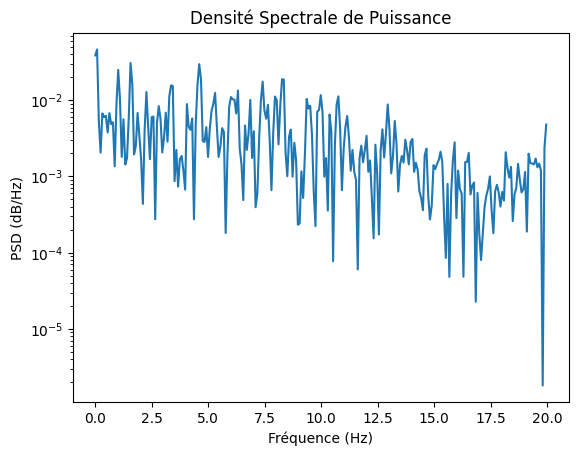

In [58]:
dsp(W, True)

c:\miniconda\envs\molonari\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\miniconda\envs\molonari\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


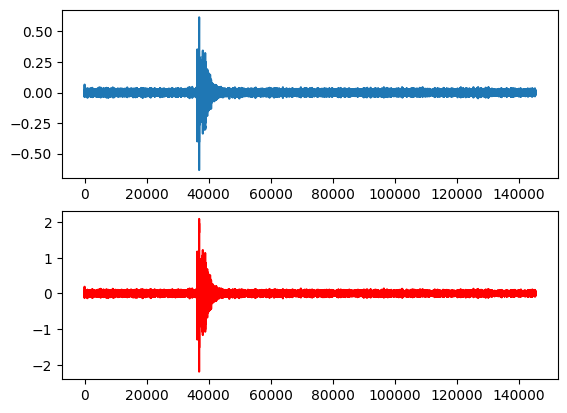

In [54]:
x = np.arange(len(s)) / fs
plt.subplot(2,1,1)
plt.plot(x, s)
plt.subplot(2,1,2)
x = np.arange(len(y_low)) / fs
plt.plot(x, y_low, color = 'r')

c:\miniconda\envs\molonari\lib\site-packages\scipy\signal\_spectral_py.py:1814: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
C:\Users\Lidia\AppData\Local\Temp\ipykernel_9992\3174940314.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto', cmap='jet')


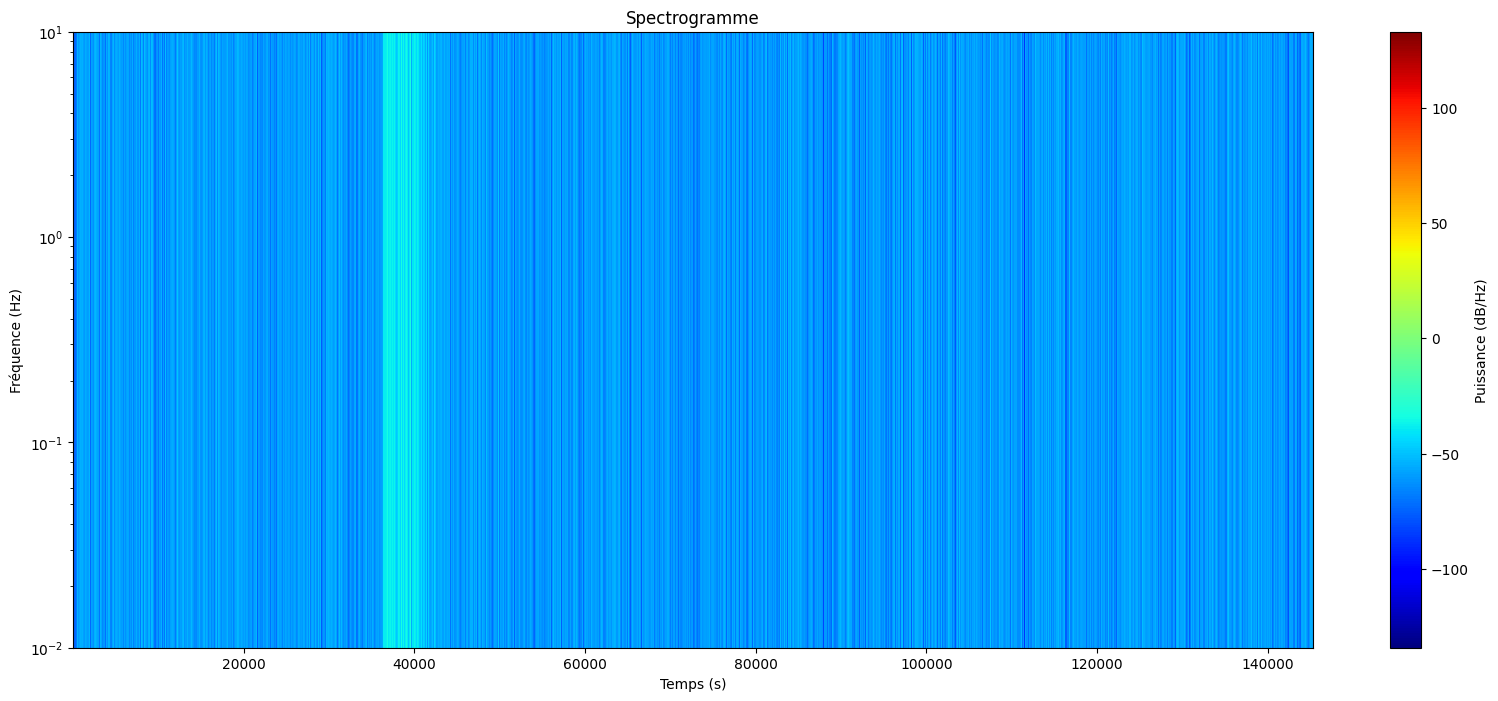

In [38]:
frequencies, times, Sxx = signal.spectrogram(s, fs, nperseg=1500, noverlap=1300)
plt.figure(figsize=(20,8))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto', cmap='jet')
plt.title('Spectrogramme')
plt.xlabel('Temps (s)')
plt.ylabel('Fréquence (Hz)')
plt.yscale('log')
plt.ylim([.01, 10])
#plt.ylim([.5, 2])
plt.colorbar(label='Puissance (dB/Hz)')
plt.show()

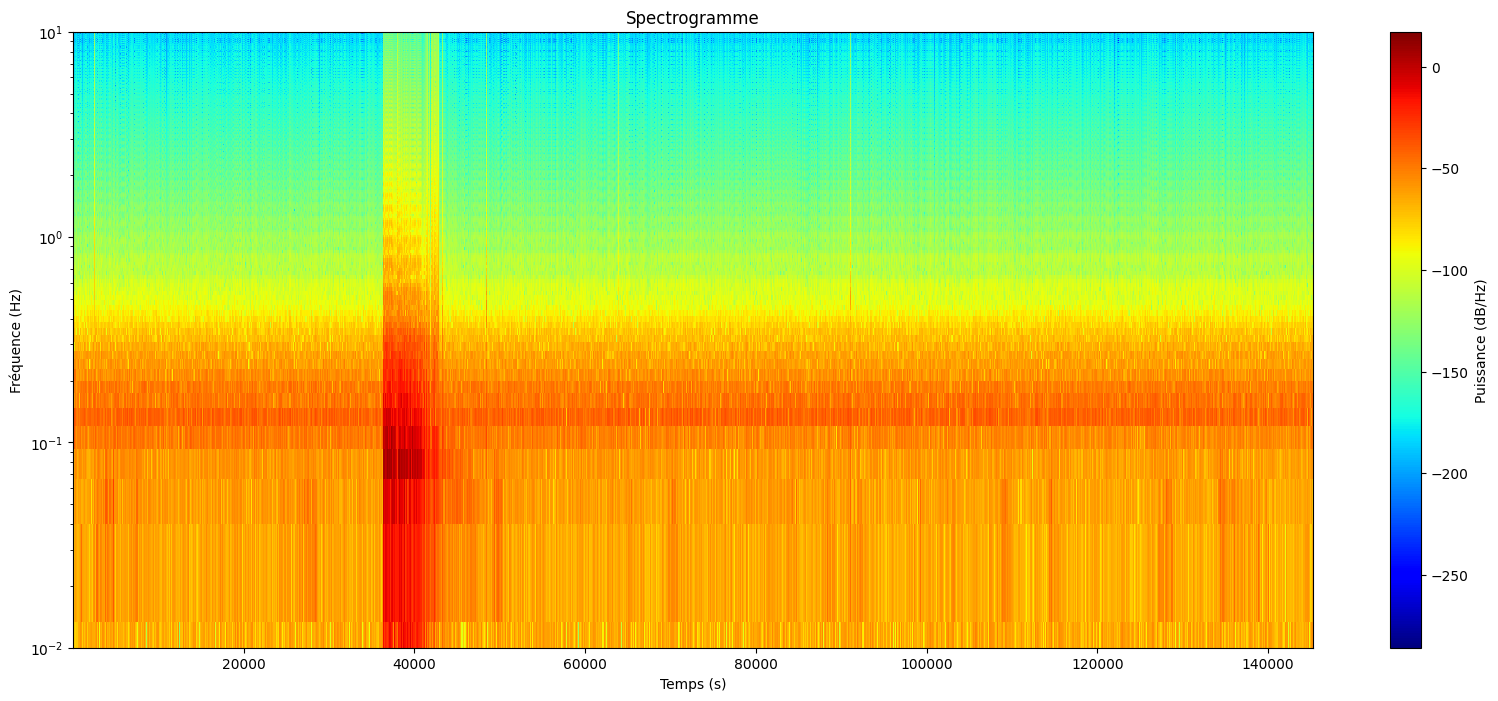

In [39]:
frequencies, times, Sxx = signal.spectrogram(y_low_w, fs, nperseg=1500, noverlap=1300)
plt.figure(figsize=(20,8))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto', cmap='jet')
plt.title('Spectrogramme')
plt.xlabel('Temps (s)')
plt.ylabel('Fréquence (Hz)')
plt.yscale('log')
plt.ylim([.01, 10])
#plt.ylim([.5, 2])
plt.colorbar(label='Puissance (dB/Hz)')
plt.show()

## Autre

In [40]:
def plot(event_i, units='seconds', plot_event = True, signal=None) :
    file = df.loc[event_i, 'file']
    print(file)
    fs = 40.
    y = np.fromfile(file, dtype=np.int32)
    if signal is not None :
        y = signal

    if units == 'date' :
        x = np.arange(len(y)) / fs
        date = df.loc[event_i, 'recording_date_time']
        timestamps = [date + timedelta(seconds=t) for t in x]
        plt.figure(figsize=(20, 8))
        plt.plot(timestamps, y)

        if plot_event :
            event_date = df.loc[event_i, 'event_date_time']
            plt.axvline(event_date, color='r')
    elif units == 'seconds' :
        x = np.arange(len(y)) / fs
        plt.figure(figsize=(20, 8))
        plt.plot(x, y)

        if plot_event :
            event_date = df.loc[event_i, 'event_date_time']
            start_date = df.loc[event_i, 'recording_date_time']
            event = (event_date - start_date).total_seconds()
            print(event)
            plt.axvline(event, color='r')


In [41]:
def bp(y, fs=40, lowcut=.05, highcut=.1, order=3) :
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.lfilter(b, a, y)
def hp(y, fs=40, lowcut=.5, highcut=2, order=3) :
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.lfilter(b, a, y)
def sta_lta(y, fs=40, sta=10*60, lta=3*3600) :
    sta = int(sta * fs)
    lta = int(lta * fs)
    sta = signal.convolve(y**2, np.ones(sta)/sta, 'same')
    lta = signal.convolve(y**2, np.ones(lta)/lta, 'same')
    return sta / lta
def bs(y, fs=40, lowcut=.1, highcut=2, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandstop')
    return signal.lfilter(b, a, y)

In [42]:
fichier_numero = 2

data/DonneesB23/2018-12/2018-12-23/2018-12-23T20_19_50.050000


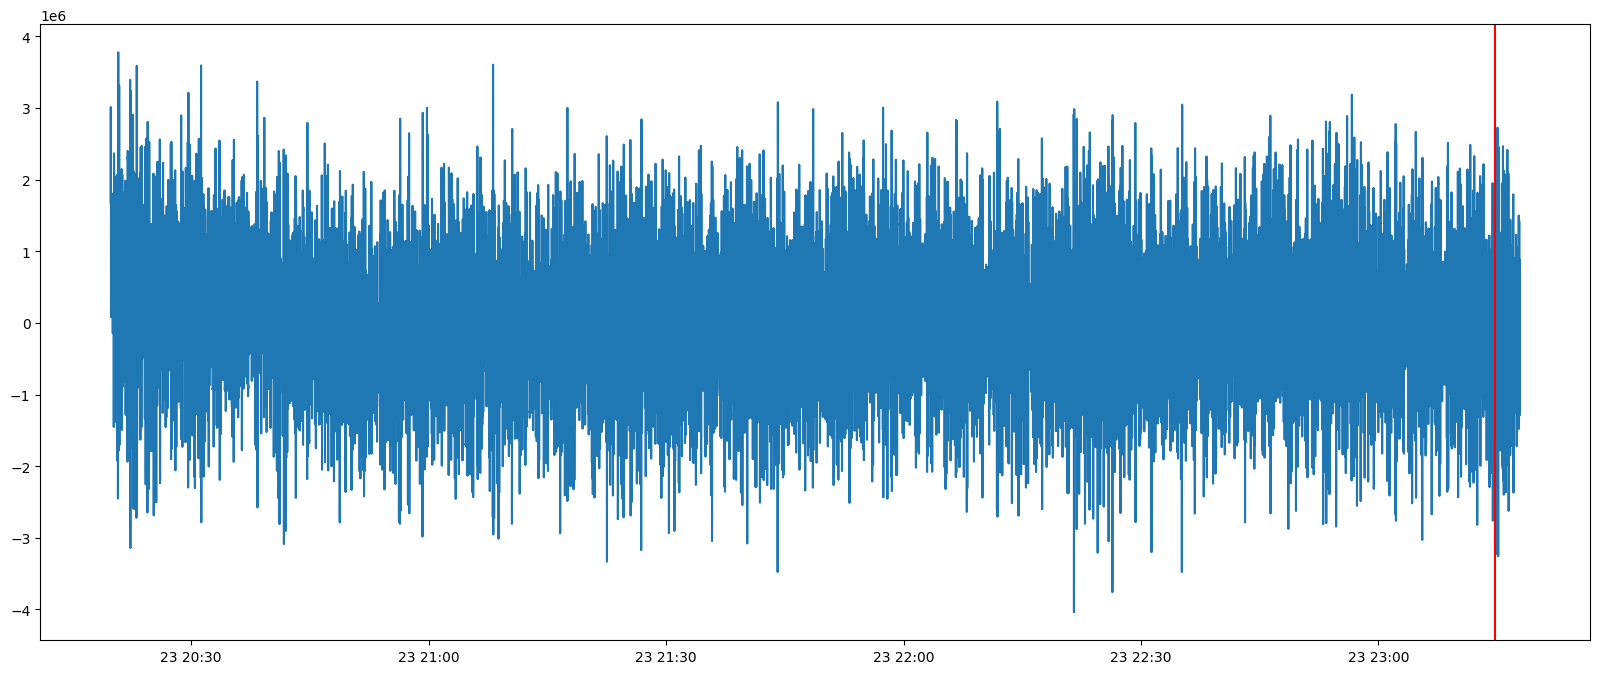

In [43]:
y = get_file(fichier_numero)
plot(fichier_numero, units='date', plot_event=True)

data/DonneesB23/2018-12/2018-12-23/2018-12-23T20_19_50.050000


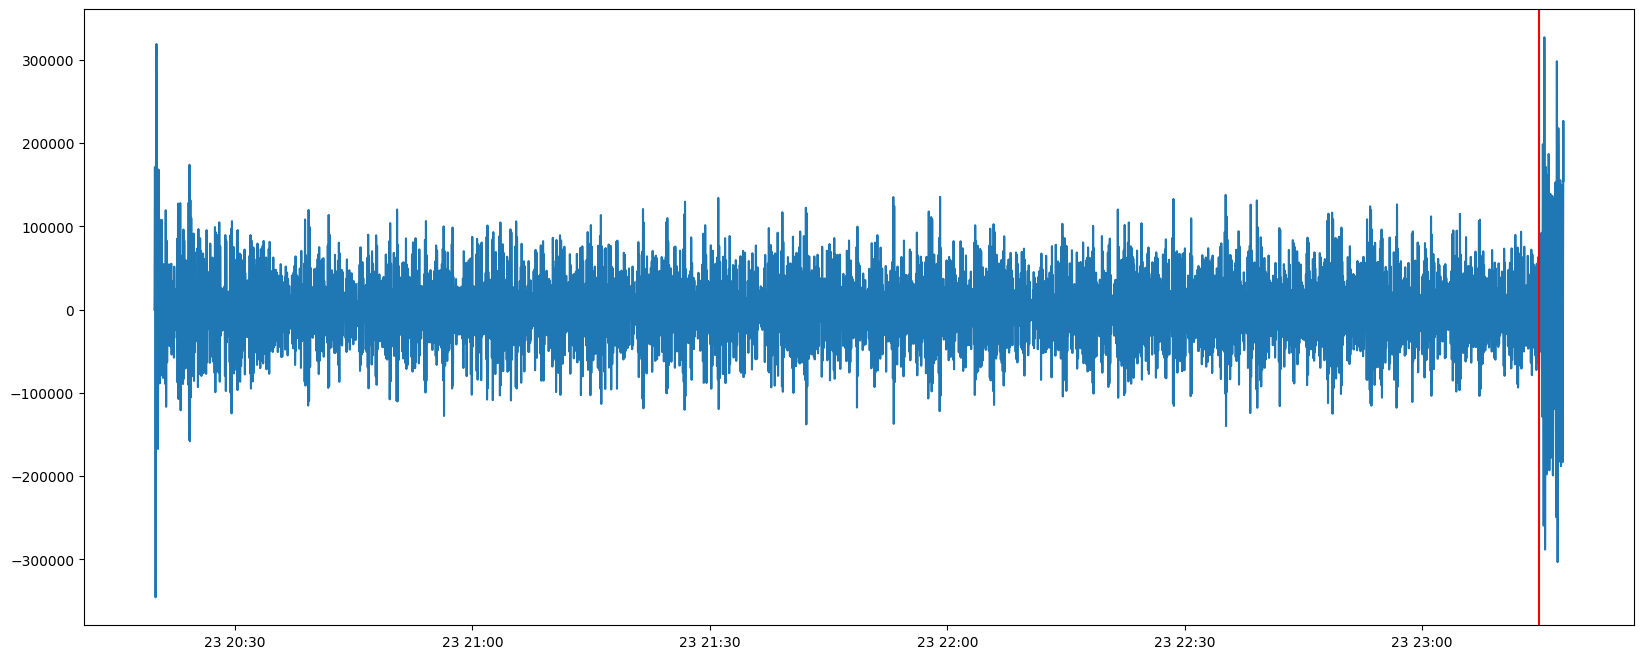

In [44]:
y_low = bp(y)
plot(fichier_numero, units='date', plot_event=True, signal=y_low)

data/DonneesB23/2019-02/2019-02-22/2019-02-22T00_23_05.800000
36290.0
data/DonneesB23/2019-02/2019-02-22/2019-02-22T00_23_05.800000
36290.0
[-0.0013945  -0.00150017 -0.00160664 ...  0.00440691  0.0043957
  0.00438299]
data/DonneesB23/2019-02/2019-02-22/2019-02-22T00_23_05.800000
36290.0
data/DonneesB23/2019-02/2019-02-22/2019-02-22T00_23_05.800000
36290.0
data/DonneesB23/2019-02/2019-02-22/2019-02-22T00_23_05.800000
36290.0
data/DonneesB23/2019-02/2019-02-22/2019-02-22T00_23_05.800000
36290.0
data/DonneesB23/2019-02/2019-02-22/2019-02-22T00_23_05.800000
36290.0


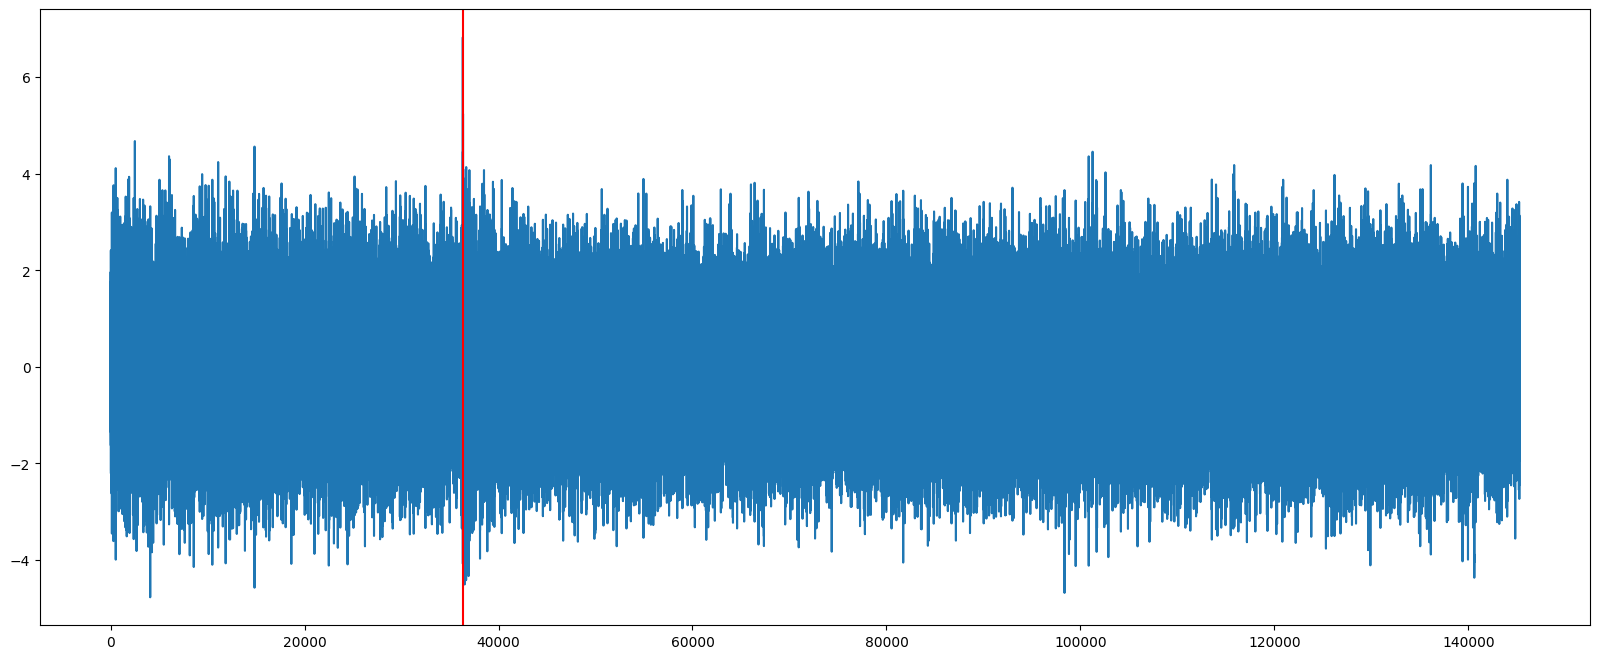

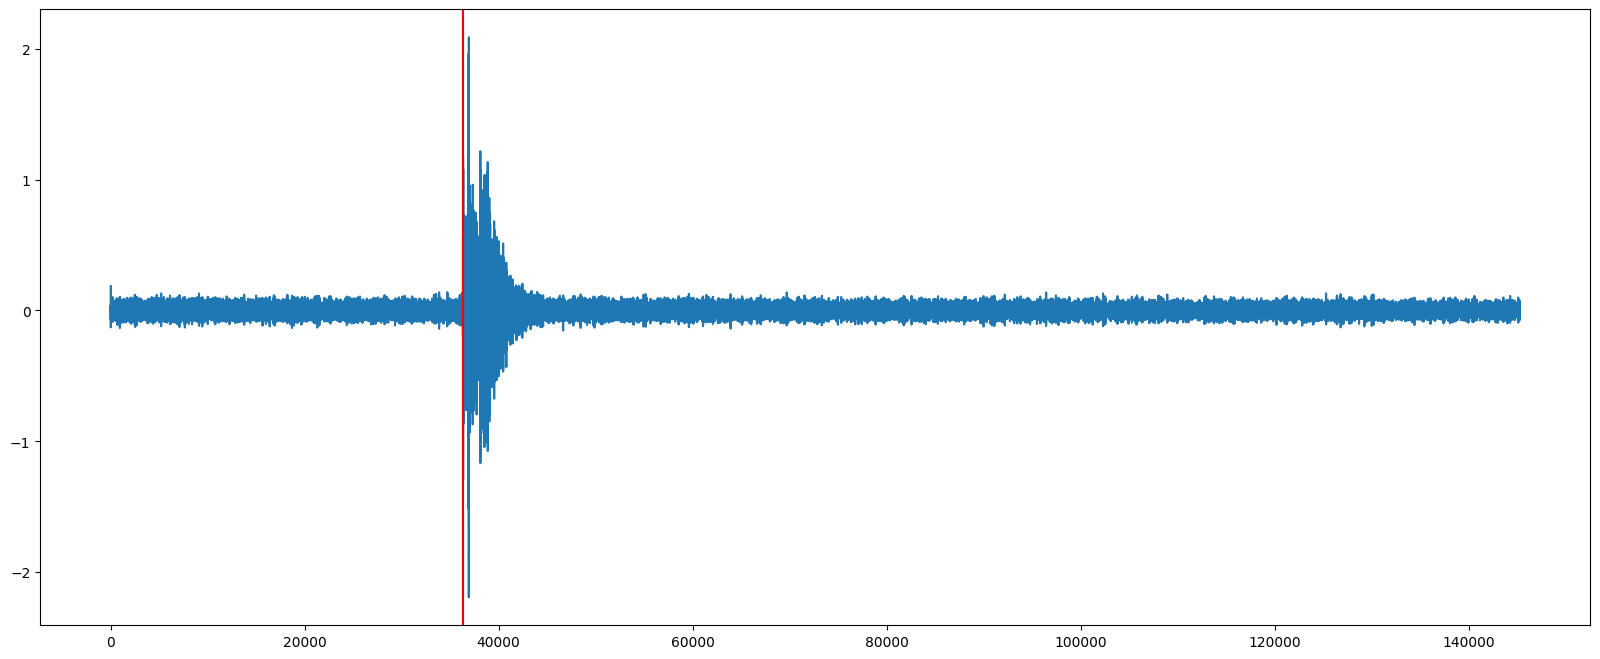

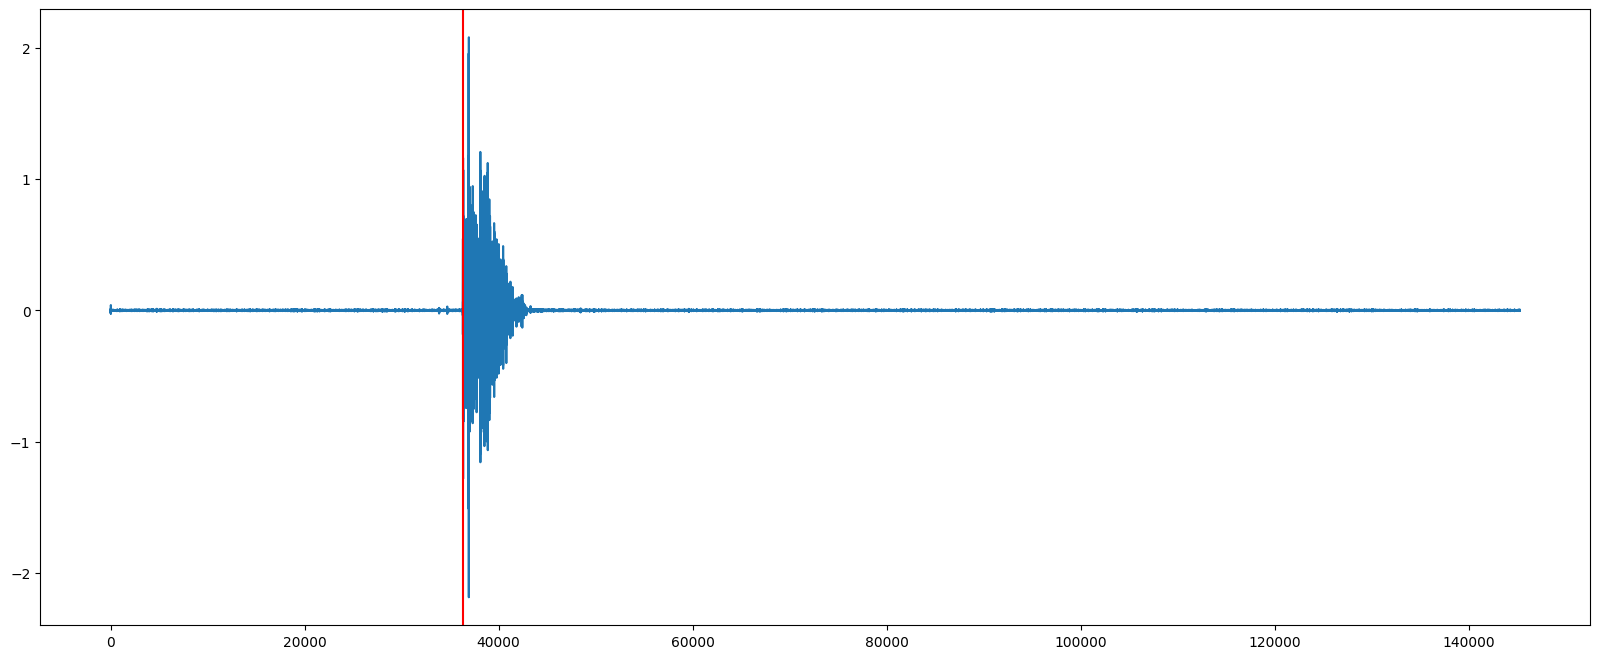

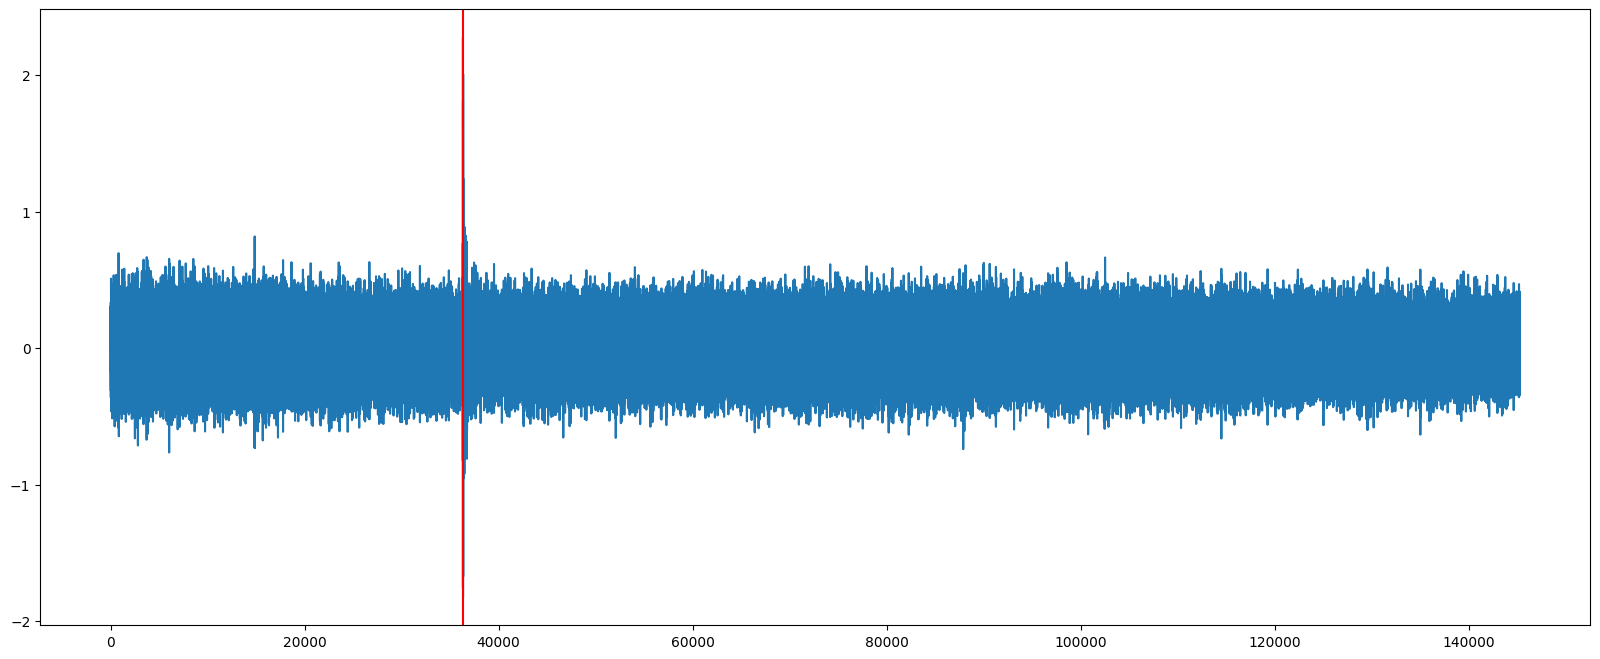

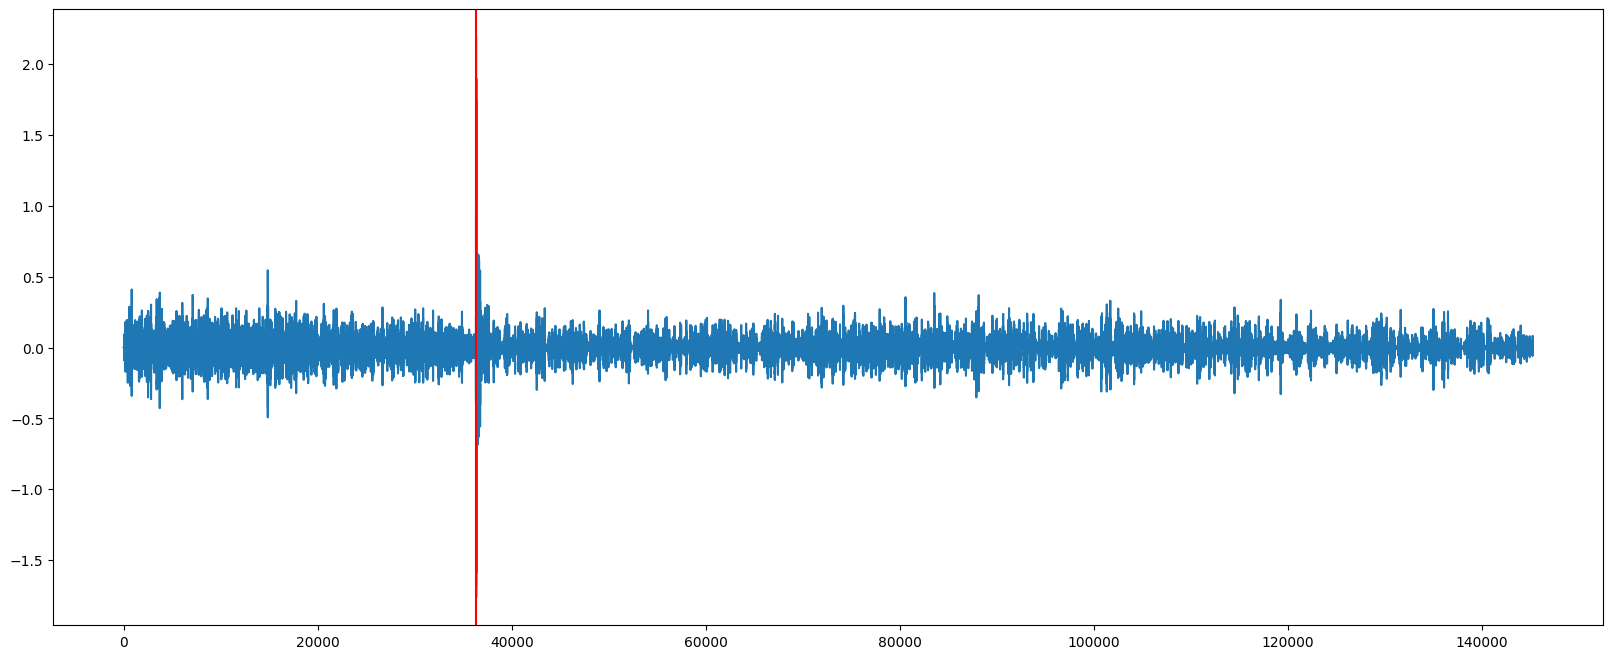

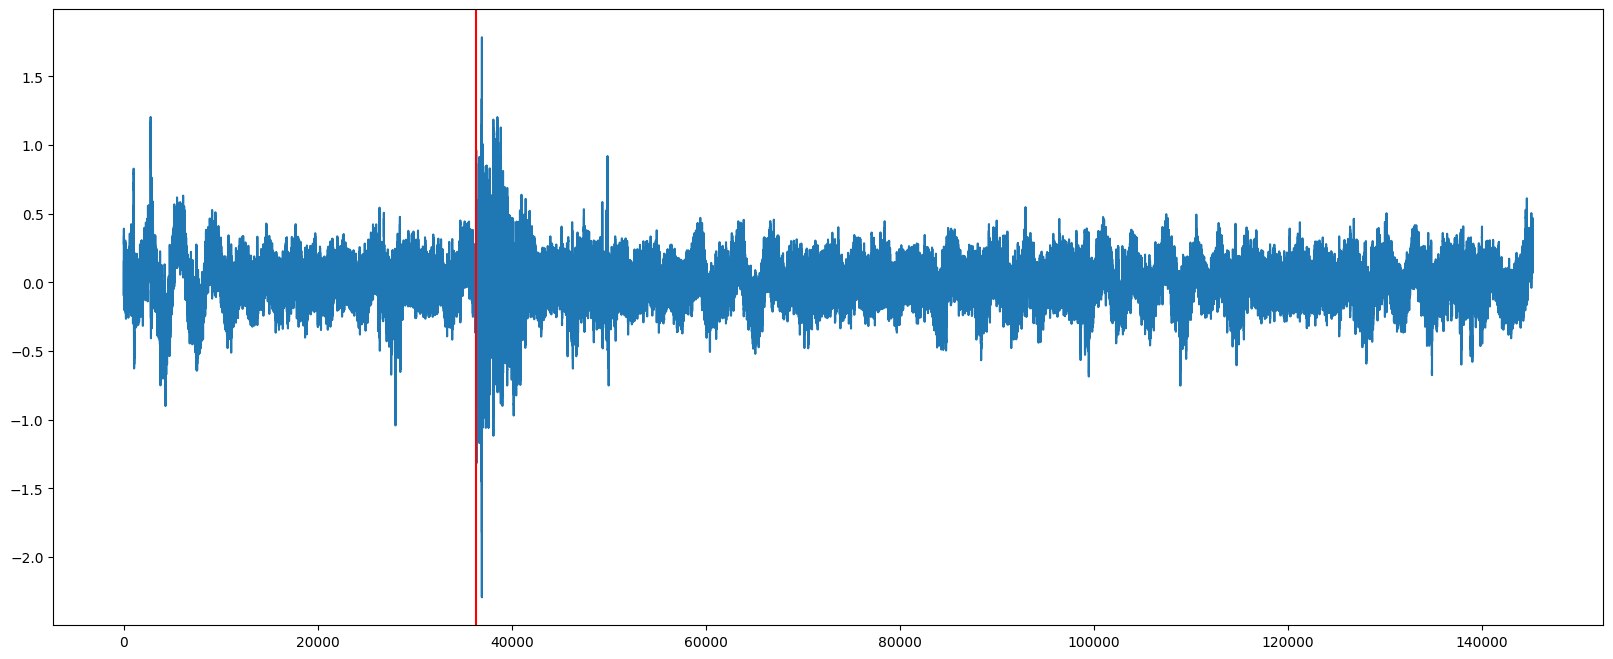

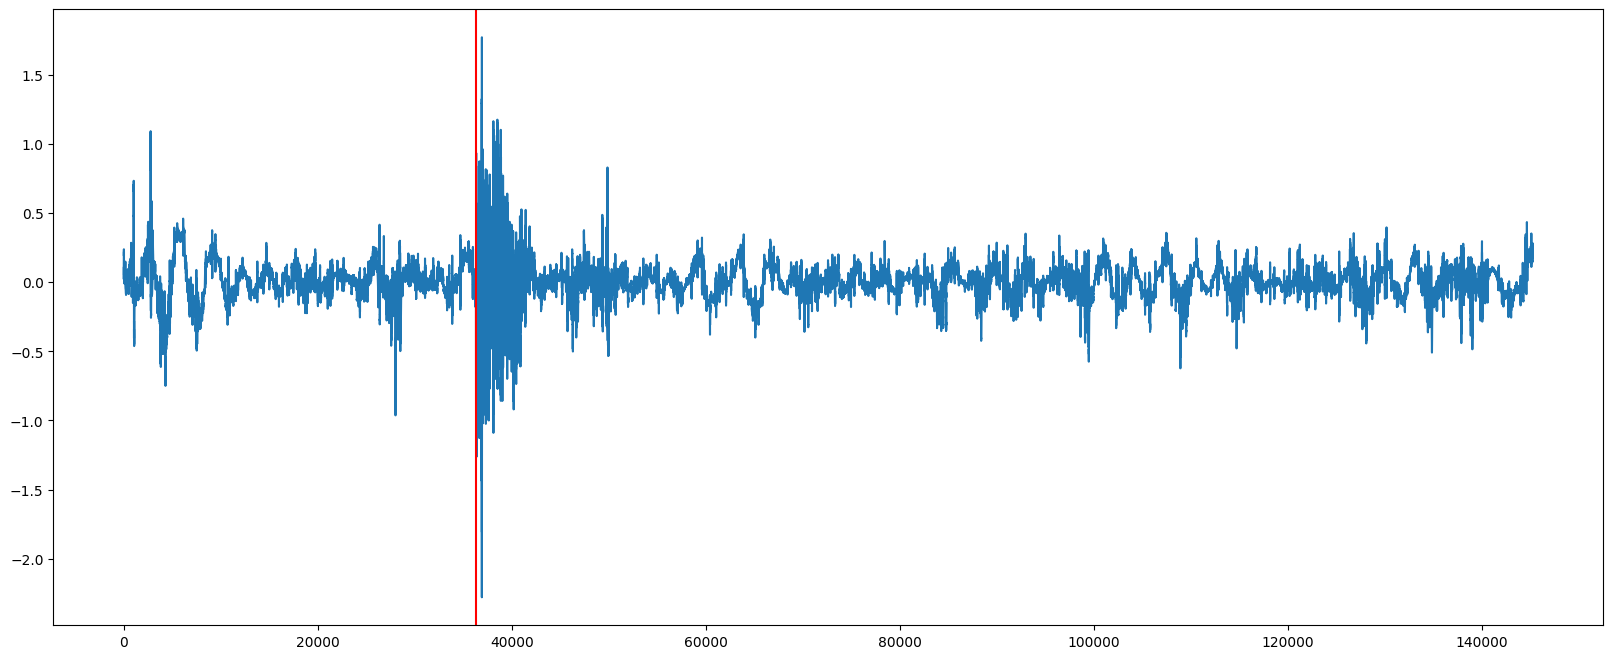

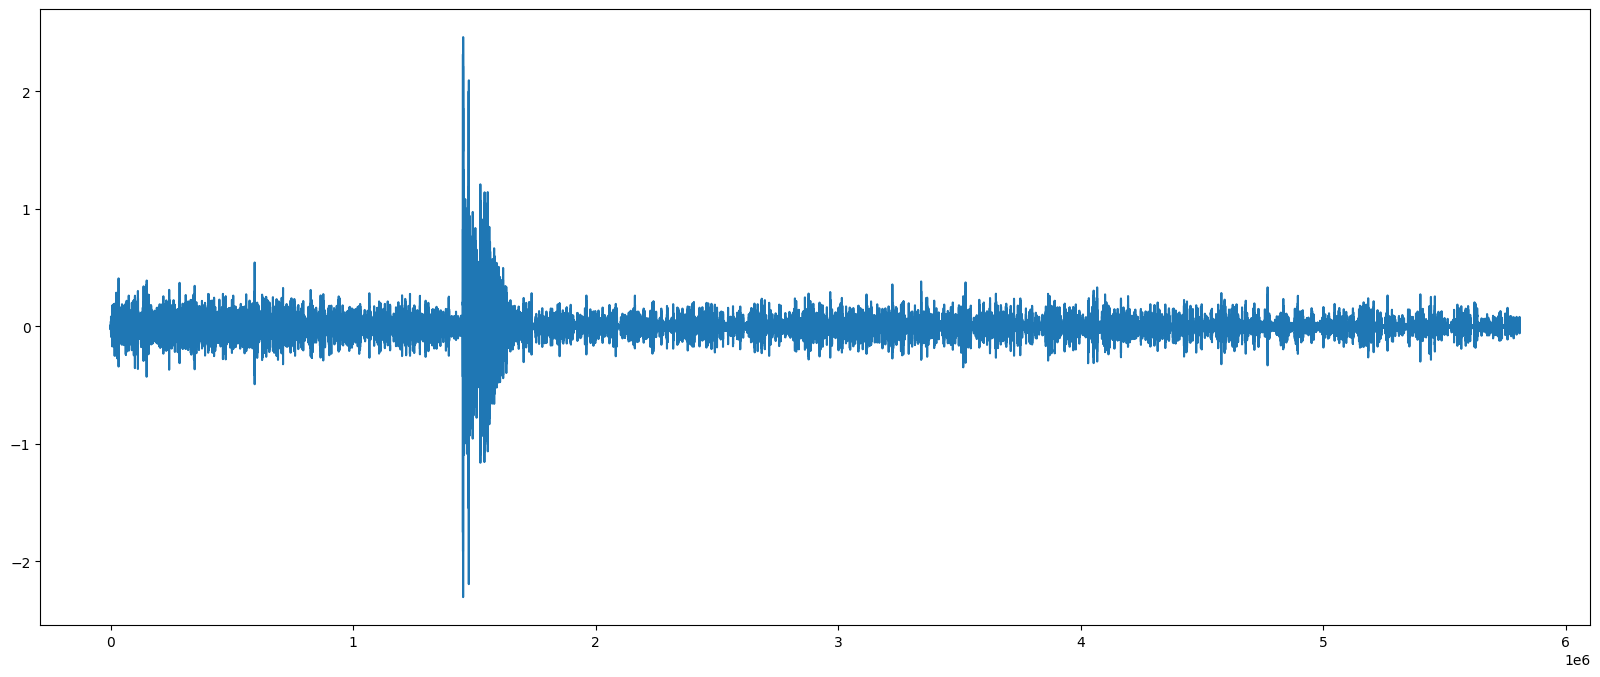

In [45]:
fichier_numero = 3
y = get_file(fichier_numero)
y = (y-np.mean(y)) / np.std(y)
plot(fichier_numero, units='seconds', plot_event=True, signal=y)
y_low = bp(y)
plot(fichier_numero, units='seconds', plot_event=True, signal=y_low)
y_low_w = signal.wiener(y_low, mysize=1000)
print(y_low_w)
plot(fichier_numero, units='seconds', plot_event=True, signal=y_low_w)
y_high = hp(y)
plot(fichier_numero, units='seconds', plot_event=True, signal=y_high)
y_high_w = signal.wiener(y_high, mysize=1000)
plot(fichier_numero, units='seconds', plot_event=True, signal=y_high_w)
y_cut = bs(y)
plot(fichier_numero, units='seconds', plot_event=True, signal=y_cut)
y_cut_w = signal.wiener(y_cut, mysize=1000)
plot(fichier_numero, units='seconds', plot_event=True, signal=y_cut_w)
plt.figure(figsize=(20, 8))
plt.plot(y_low_w+y_high_w)

[-0.0013945  -0.00150017 -0.00160664 ...  0.00440691  0.0043957
  0.00438299]
data/DonneesB23/2019-02/2019-02-22/2019-02-22T00_23_05.800000
36290.0


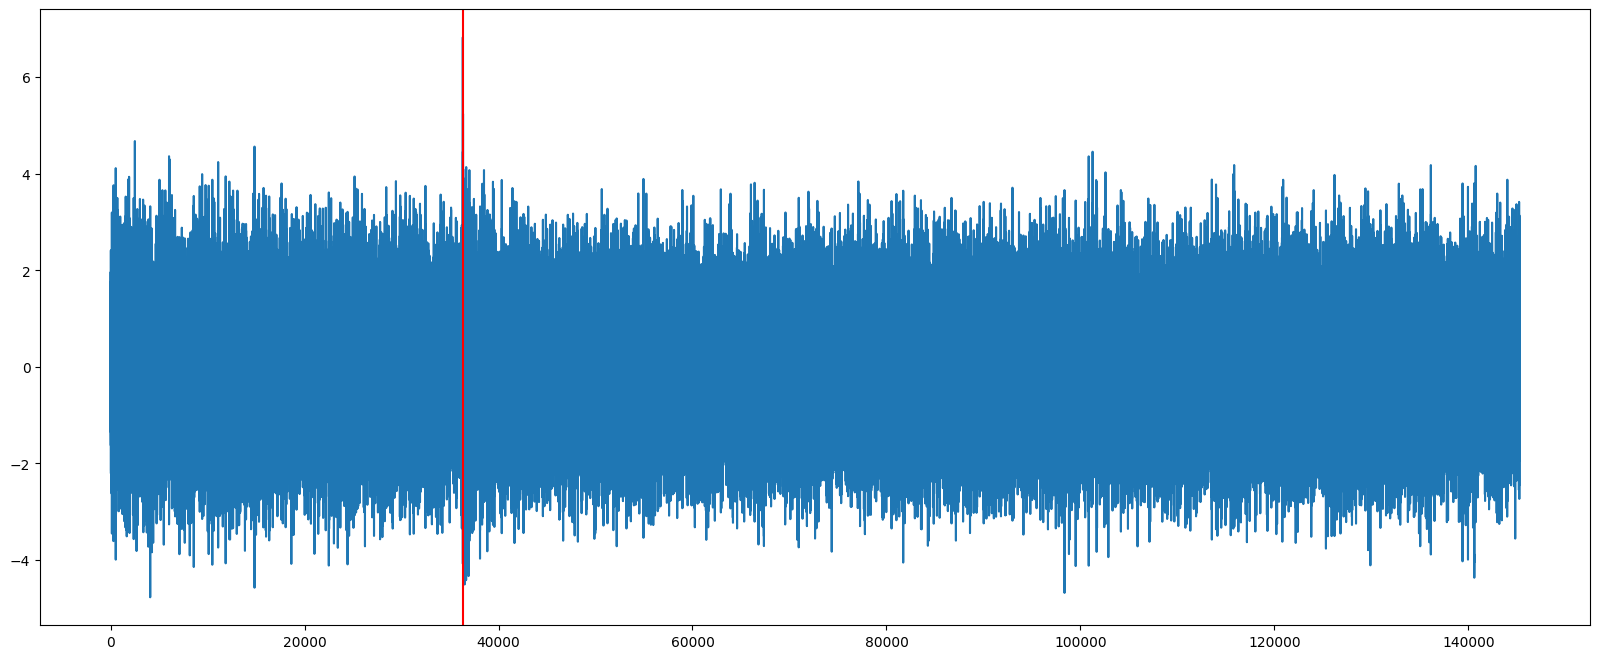

In [46]:
y_low_w = signal.wiener(y_low, mysize=1000)
print(y_low_w)
plot(fichier_numero, units='seconds', plot_event=True, signal=y)

In [47]:
b = Y[0][:7000]

In [48]:
y = Y[0][36290:43290]

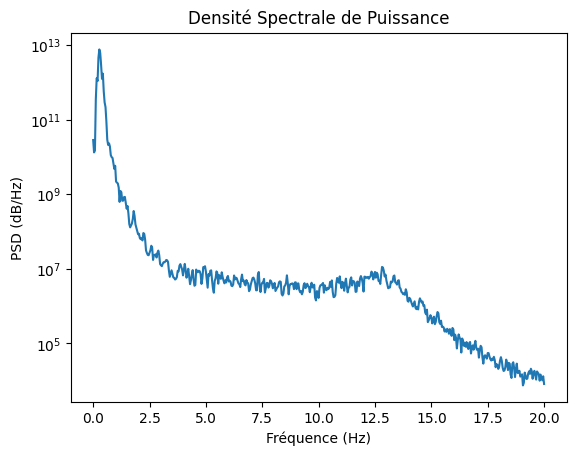

In [49]:
# Générer un signal exemple
fs = 40  # Fréquence d'échantillonnage en Hz

frequencies, psd = signal.welch(y, fs, nperseg=1024)

# Tracer la DSP
plt.semilogy(frequencies, psd)
# Tracer la PSD
plt.title('Densité Spectrale de Puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('PSD (dB/Hz)')
plt.show()

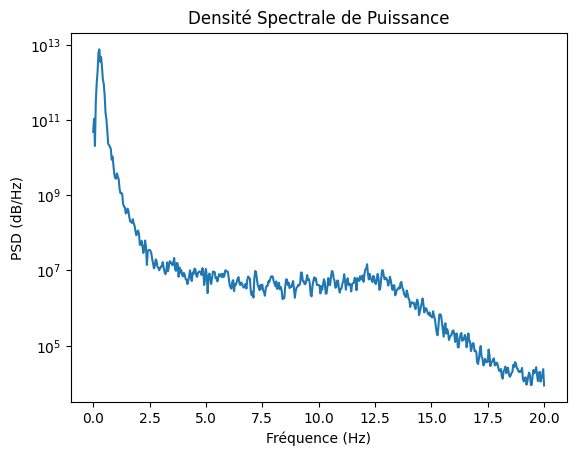

In [50]:
freq_b, psd_b = signal.welch(b, fs, nperseg=1024)
# Tracer la DSP
plt.semilogy(freq_b, psd_b)
# Tracer la PSD
plt.title('Densité Spectrale de Puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('PSD (dB/Hz)')
plt.show()

In [51]:
def end(y):
    y.tolist()
    n = len(y)
    I = []
    for i in range(n-1):
        if y[i + 1] - y[i]>10**(-2):
            I.append(i)
        else:
            pass
    return I

In [52]:
print(y_low_w)

[-0.0013945  -0.00150017 -0.00160664 ...  0.00440691  0.0043957
  0.00438299]
